Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] If you haven't completed assignment #1, please do so first.
- [X] Continue to clean and explore your data. Make exploratory visualizations.
- [X] Fit a model. Does it beat your baseline? 
- [X] Try xgboost.
- [X] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

### some eda and feature engineering

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('../data/tribeca.csv')
df=df.drop('Unnamed: 0',axis=1)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,222,1013,NaN,R4,"181 HUDSON STREET, 6D",6D,...,1.0,0.0,1.0,"7,878",1840.0,1909.0,2,R4,2800000,2019-01-03
1,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,9022,NaN,R4,"10 LITTLE WEST STREET, 19A",19A,...,1.0,0.0,1.0,0,1759.0,0.0,2,R4,2650000,2019-01-07
2,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,1441,NaN,R4,"30 LITTLE WEST STREET, 7G",7G,...,1.0,0.0,1.0,0,1190.0,2005.0,2,R4,1005000,2019-01-09
3,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,3624,NaN,R4,"2 RIVER TERRACE, 4C",4C,...,1.0,0.0,1.0,0,1088.0,2006.0,2,R4,1678000,2019-01-10
4,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,2610,NaN,R4,"380 RECTOR PLACE, 10A",10A,...,1.0,0.0,1.0,0,873.0,0.0,2,R4,1380000,2019-01-11


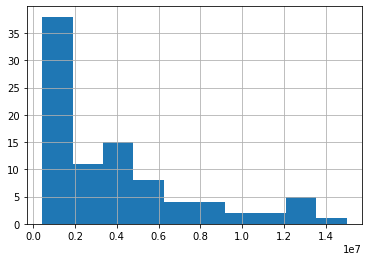

In [13]:
df['LOG_PRICE']=np.log1p(df.SALE_PRICE)
df.SALE_PRICE.hist();

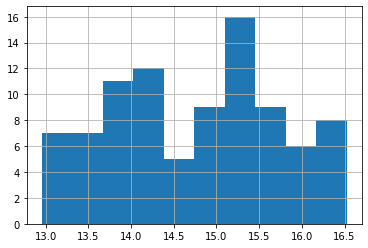

In [14]:
df.LOG_PRICE.hist();

### train the baseline model

In [21]:
# Going to get a list of the categorical variables an the numeric valiables and take a look at a baseline
# model
target = 'LOG_PRICE'

cat=df.select_dtypes(exclude='number')
num=df.select_dtypes(exclude='object')

# filter out unwanted features like dates
ignore=['ZIP_CODE','SALE_DATE','SALE_PRICE','LOG_PRICE']
cat=[x for x in cat if x not in ignore]
num=[x for x in num if x not in ignore]
features=cat+num

# validation split
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,random_state=42)
train,val=train_test_split(train,random_state=42)

# feature sets
X_train=train[features]
X_val=val[features]
X_test=test[features]

y_train=train[target]
y_val=val[target]
y_test=test[target]

print("(train shape)(val shape)(test shape)")
train.shape,val.shape,test.shape

(train shape)(val shape)(test shape)


((50, 22), (17, 22), (23, 22))

In [26]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LinearRegression(n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print("training r^2 is:",pipeline.score(X_train,y_train))
print("validation r^2 is:",pipeline.score(X_val,y_val))


training r^2 is: 0.797478474822824
validation r^2 is: 0.8652032879751262


### finding feature importance

In [48]:
import eli5
from eli5.sklearn import PermutationImportance
# make a transformation pipeline
autobot=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
# make the transformed feature matrixs
X_train_encoded=autobot.fit_transform(X_train,y_train)
X_val_encoded=autobot.transform(X_val)

# fit the model with the transformed information
model=LinearRegression(n_jobs=-1)
model.fit(X_train_encoded,y_train)

# make a permutation importance finder
permuter=PermutationImportance(
    model,
    scoring=None,
    n_iter=5,
    random_state=42
)
# fit the premuter to the validation set
permuter.fit(X_val_encoded,y_val)

PermutationImportance(cv='prefit',
                      estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True, n_jobs=-1,
                                                 normalize=False),
                      n_iter=5, random_state=42, refit=True, scoring=None)

In [56]:
feature_names = X_val.columns.tolist()
# getting an error without poping an item of the list
feature_names.pop()
pd.Series(permuter.feature_importances_, feature_names).sort_values().index

Index(['LOT', 'NEIGHBORHOOD', 'COMMERCIAL_UNITS', 'RESIDENTIAL_UNITS',
       'EASE-MENT', 'BOROUGH', 'TAX_CLASS_AT_PRESENT', 'APARTMENT_NUMBER',
       'ADDRESS', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_CATEGORY',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'YEAR_BUILT', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'BLOCK', 'TOTAL_UNITS'],
      dtype='object')

In [55]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.0211 ± 0.7197,TOTAL_UNITS
0.0307 ± 0.0173,BLOCK
0.0142 ± 0.0200,GROSS_SQUARE_FEET
0.0141 ± 0.0124,LAND_SQUARE_FEET
0.0000 ± 0.0000,YEAR_BUILT
0.0000 ± 0.0000,BUILDING_CLASS_AT_TIME_OF_SALE
0.0000 ± 0.0000,BUILDING_CLASS_CATEGORY
0.0000 ± 0.0000,BUILDING_CLASS_AT_PRESENT
0.0000 ± 0.0000,ADDRESS
0.0000 ± 0.0000,APARTMENT_NUMBER


### now that i know what features have a signifigant impact im going to filer thoose out and retest with the baseline and see if there is an improvement

In [57]:
# Going to get a list of the categorical variables an the numeric valiables and take a look at a baseline
# model
target = 'LOG_PRICE'

cat=df.select_dtypes(exclude='number')
num=df.select_dtypes(exclude='object')

# filter out unwanted features like dates
ignore=['ZIP_CODE','SALE_DATE','SALE_PRICE','LOG_PRICE','LOT', 'NEIGHBORHOOD', 'COMMERCIAL_UNITS', 'RESIDENTIAL_UNITS',
       'EASE-MENT', 'BOROUGH', 'TAX_CLASS_AT_PRESENT', 'APARTMENT_NUMBER',
       'ADDRESS', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_CATEGORY',
       'BUILDING_CLASS_AT_TIME_OF_SALE']
cat=[x for x in cat if x not in ignore]
num=[x for x in num if x not in ignore]
features=cat+num

# validation split
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,random_state=42)
train,val=train_test_split(train,random_state=42)

# feature setsa
X_train=train[features]
X_val=val[features]
X_test=test[features]

y_train=train[target]
y_val=val[target]
y_test=test[target]

print("(train shape)(val shape)(test shape)")
train.shape,val.shape,test.shape

(train shape)(val shape)(test shape)


((50, 22), (17, 22), (23, 22))

In [58]:
pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LinearRegression(n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print("training r^2 is:",pipeline.score(X_train,y_train))
print("validation r^2 is:",pipeline.score(X_val,y_val))


training r^2 is: 0.792294530677215
validation r^2 is: 0.8792184637174599


### time to test a diffrent model and see if there is an improvement

In [60]:
from xgboost import XGBRegressor

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBRegressor(n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print("training r^2 is:",pipeline.score(X_train,y_train))
print("validation r^2 is:",pipeline.score(X_val,y_val))

[16:27:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
training r^2 is: 0.9856834861233454
validation r^2 is: 0.9560917476283507


### seems like it's overfitting a little bit so im going to do some hyper param tunning

In [82]:
# A parameter grid for XGBoost
#'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
#'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

from xgboost import XGBRegressor

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBRegressor(max_depth=2,learning_rate=0.3,n_estimators=50,n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print("training r^2 is:",pipeline.score(X_train,y_train))
print("validation r^2 is:",pipeline.score(X_val,y_val))

[16:32:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
training r^2 is: 0.9828680284138049
validation r^2 is: 0.958026879369756


In [83]:
test_score=pipeline.score(X_test,y_test)
print("testing score:",test_score)

testing score: 0.8962361830563327
